<a href="https://colab.research.google.com/github/saumya-699/Data-Analytics-Process-and-Interpretation/blob/main/Data_Analytics_Process_and_Interpretation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [50]:
# --------------------------
# 1. DATA LOADING & INSPECTION
# --------------------------



In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from imblearn.over_sampling import SMOTE


In [52]:
from google.colab import drive
drive.mount('/content/drive')
data = pd.read_csv('/content/drive/MyDrive/BIS/diabetes.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [53]:
# =====================
# 2. DATA EXPLORATION
# =====================
# Basic statistics showing potential missing values (zeros)

In [54]:
print("Initial Statistics:")
print(data.describe())

Initial Statistics:
       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000   99.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    31.992578                  0.471876   33.240885    0.348958  
std      7.884160                  0.331329   11.760232    0.476951  
min      0.0000

In [55]:
# Dataset structure information
print("\nData Structure:")
data.info()


Data Structure:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [56]:
# Check data dimensions
print(f"\nDataset Shape: {data.shape}")


Dataset Shape: (768, 9)


In [57]:
# Value distribution check
print("\nValue Counts Analysis:")
print(data.value_counts())


Value Counts Analysis:
Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin  BMI   DiabetesPedigreeFunction  Age  Outcome
0            57       60             0              0        21.7  0.735                     67   0          1
             67       76             0              0        45.3  0.194                     46   0          1
5            103      108            37             0        39.2  0.305                     65   0          1
             104      74             0              0        28.8  0.153                     48   0          1
             105      72             29             325      36.9  0.159                     28   0          1
                                                                                                            ..
2            84       50             23             76       30.4  0.968                     21   0          1
             85       65             0              0        39.6  0.930                     

In [58]:
# Column names verification
print("\nColumns:", data.columns.tolist())



Columns: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']


In [59]:
# Missing values check (explicit nulls)
print("\nExplicit Missing Values:")
print(data.isnull().sum())



Explicit Missing Values:
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


In [60]:
# Check duplicates
print("\nDuplicate Check:")
print(data[data.duplicated()])


Duplicate Check:
Empty DataFrame
Columns: [Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DiabetesPedigreeFunction, Age, Outcome]
Index: []


In [61]:
# =====================
# 3. DATA CLEANING
# =====================
# Handle biological zeros (implicit missing values)
# Median imputation for normally distributed features

In [62]:
median_cols = ['Glucose', 'BloodPressure', 'BMI']
data[median_cols] = data[median_cols].replace(0, np.nan).fillna(data[median_cols].median())

In [63]:
import numpy as np
from sklearn.impute import KNNImputer

# Replace zeros with NaN in KNN columns
knn_cols = ['SkinThickness', 'Insulin']
data[knn_cols] = data[knn_cols].replace(0, np.nan)

# Apply KNN imputation
knn_imputer = KNNImputer(n_neighbors=5)
data[knn_cols] = knn_imputer.fit_transform(data[knn_cols])

# Check if any zeros remain
print(f"Remaining zeros in {knn_cols}:\n", (data[knn_cols] == 0).sum())


Remaining zeros in ['SkinThickness', 'Insulin']:
 SkinThickness    0
Insulin          0
dtype: int64


In [64]:
def cap_outliers(data):
    for col in data.select_dtypes(include=np.number):
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        data[col] = np.where(data[col] < lower_bound, lower_bound, data[col])
        data[col] = np.where(data[col] > upper_bound, upper_bound, data[col])
    return data

data = cap_outliers(data)


In [65]:
# =====================
# 4. EXPLORATORY DATA ANALYSIS
# =====================
# Outcome distribution analysis

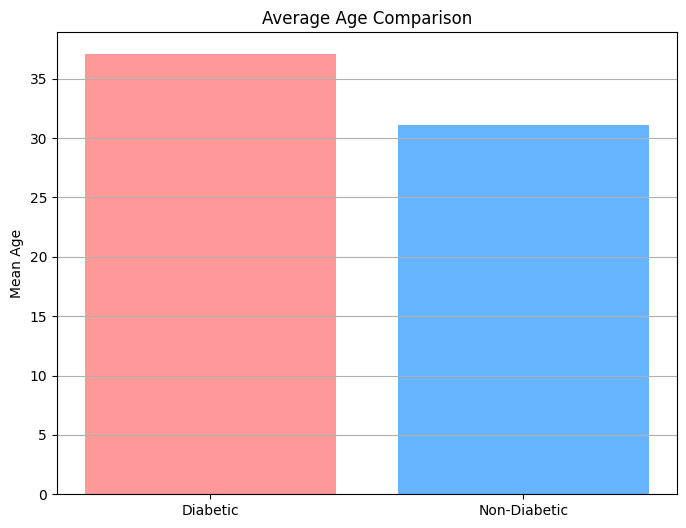

In [66]:
# Age comparison analysis
diabetic = data[data['Outcome']==1]
non_diabetic = data[data['Outcome']==0]

plt.figure(figsize=(8,6))
plt.bar(["Diabetic", "Non-Diabetic"],
        [diabetic['Age'].mean(), non_diabetic['Age'].mean()],
        color=['#ff9999', '#66b3ff'])
plt.title("Average Age Comparison")
plt.ylabel("Mean Age")
plt.grid(axis='y')
plt.show()

In [ ]:
# Observation:
#  The average age of individuals with diabetes is higher than that of non-diabetic individuals.
#  Implication:
# Age as a Risk Factor: This suggests that age is a contributing factor to diabetes, meaning older individuals may have a higher likelihood of developing diabetes.


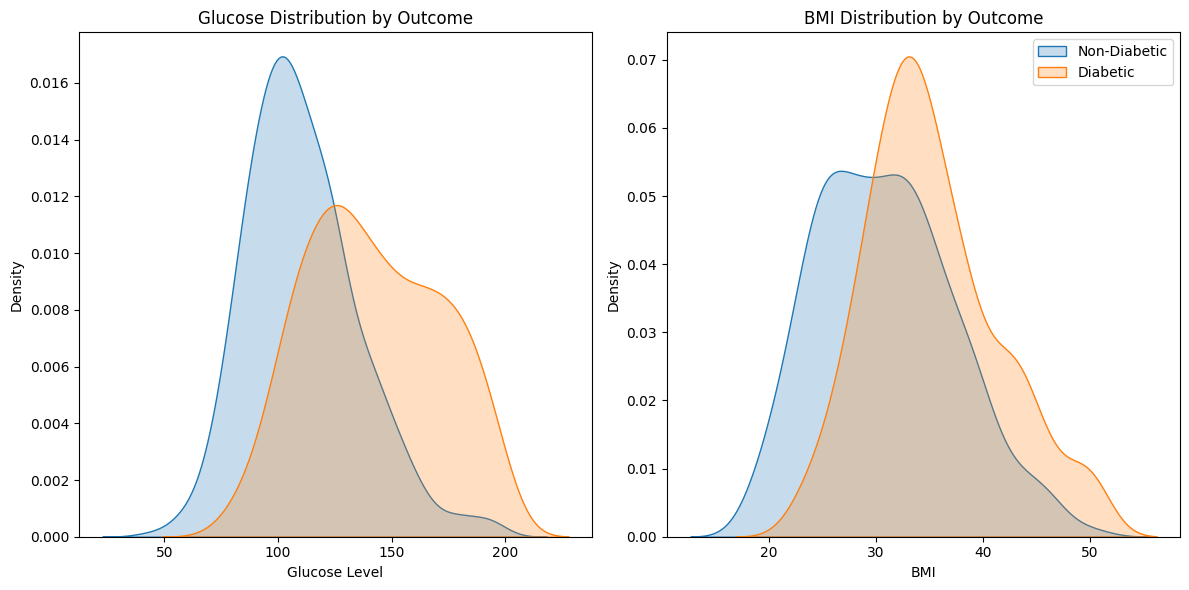

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns

# Density plots for Glucose and BMI
plt.figure(figsize=(12, 6))

# Glucose
plt.subplot(1, 2, 1)
sns.kdeplot(data[data['Outcome'] == 0]['Glucose'], label='Non-Diabetic', fill=True)
sns.kdeplot(data[data['Outcome'] == 1]['Glucose'], label='Diabetic', fill=True)
plt.title('Glucose Distribution by Outcome')
plt.xlabel('Glucose Level')
plt.ylabel('Density')

# BMI
plt.subplot(1, 2, 2)
sns.kdeplot(data[data['Outcome'] == 0]['BMI'], label='Non-Diabetic', fill=True)
sns.kdeplot(data[data['Outcome'] == 1]['BMI'], label='Diabetic', fill=True)
plt.title('BMI Distribution by Outcome')
plt.xlabel('BMI')
plt.ylabel('Density')

plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Left Graph (Glucose Level Distribution by Outcome):
# 	The distribution for diabetics (orange) is shifted to the right, meaning diabetic individuals generally have higher glucose levels.
# 	The non-diabetic group (blue) has a peak around 100 mg/dL, whereas the diabetic group peaks around 125–150 mg/dL.
# 	Implication: Higher glucose levels are associated with diabetes. In a healthcare or insurance business, this insight can help in risk assessment and early intervention strategies.
# Right Graph (BMI Distribution by Outcome):
# 	Diabetic individuals tend to have higher BMI values compared to non-diabetics.
# 	The peak for diabetics is around 35, whereas non-diabetics peak at a lower BMI.


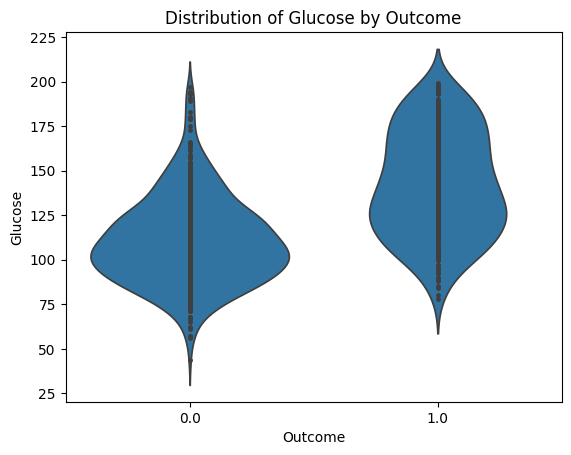

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a violin plot of Glucose distribution based on Outcome
sns.violinplot(x="Outcome", y="Glucose", data=data, inner="point")  # or inner="stick"

plt.xlabel("Outcome")
plt.ylabel("Glucose")
plt.title("Distribution of Glucose by Outcome")

plt.show()

In [ ]:
#  Diabetic individuals (Outcome = 1) have a broader distribution of glucose levels, with many cases exceeding 150 mg/dL.
#   The non-diabetic group (Outcome = 0) has a narrower range, mostly under 140 mg/dL.
#   The median glucose level for diabetics is significantly higher.


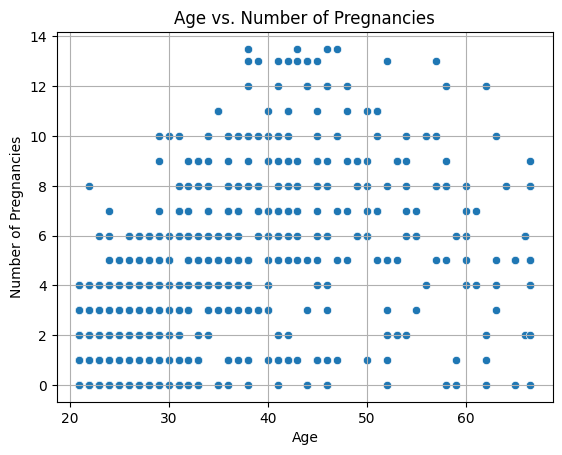

In [69]:
# This chart represent the correlation between age and number of pregnancies
sns.scatterplot(x="Age", y="Pregnancies", data=data)
plt.xlabel("Age")
plt.ylabel("Number of Pregnancies")
plt.title("Age vs. Number of Pregnancies")
plt.grid(True)
plt.show()

In [ ]:
	# Observation:
	# Younger individuals have a broader spread in the number of pregnancies.
	# Older individuals (40+) generally have more pregnancies, but there are fewer cases with extremely high counts (above 10).
	# Implication: Age and pregnancy history could be a factor in diabetes risk. Businesses in maternal health, prenatal care, and family planning services can tailor their offerings based on pregnancy-related diabetes risks.


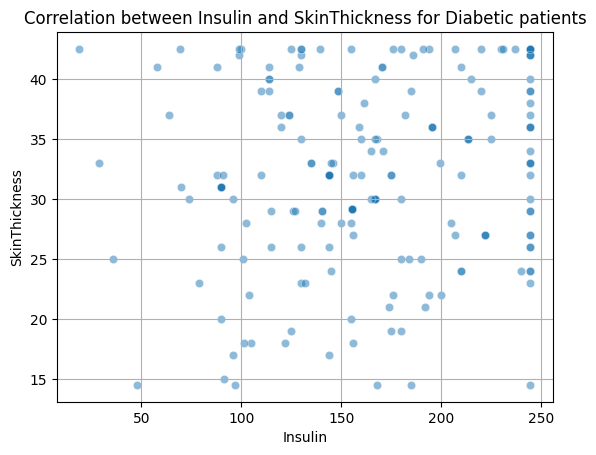

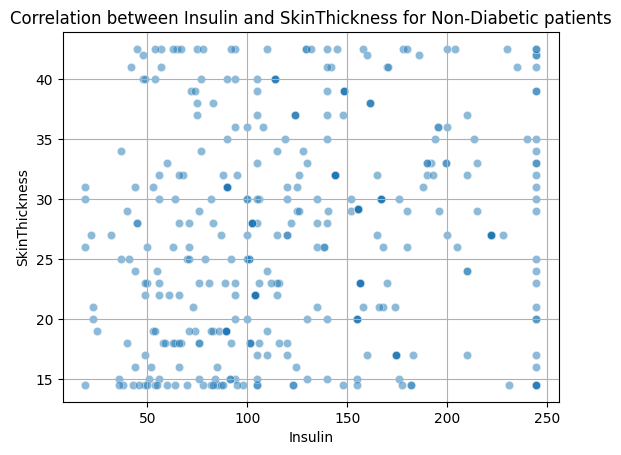

In [70]:
# Filter for diabetic and non-diabetic groups
diabetic = data[data["Outcome"] == 1]
non_diabetic = data[data["Outcome"] == 0]

# Scatterplot for diabetic patients
sns.scatterplot(x="Insulin", y="SkinThickness", data=diabetic, alpha=0.5)
plt.xlabel("Insulin")
plt.ylabel("SkinThickness")
plt.title("Correlation between Insulin and SkinThickness for Diabetic patients")
plt.grid(True)
plt.show()

# Scatterplot for non-diabetic patients
sns.scatterplot(x="Insulin", y="SkinThickness", data=non_diabetic, alpha=0.5)
plt.xlabel("Insulin")
plt.ylabel("SkinThickness")
plt.title("Correlation between Insulin and SkinThickness for Non-Diabetic patients")
plt.grid(True)
plt.show()

In [70]:
# Scatterplot for non-diabetic patient

# These are scatter plots showing the relationship between Insulin levels and SkinThickness for Diabetic and Non-Diabetic patients.
# Interpretation:
# 	Both scatter plots indicate some level of positive correlation between Insulin and SkinThickness, meaning that as insulin levels increase, skin thickness tends to increase.
# 	However, the correlation does not appear strong because the points are spread widely.
# 	Comparison between diabetic and non-diabetic patients:
# 	In diabetic patients, there seem to be more individuals with higher insulin levels and higher skin thickness.
# 	Non-diabetic patients have a more even distribution of insulin levels and skin thickness, suggesting less variability.


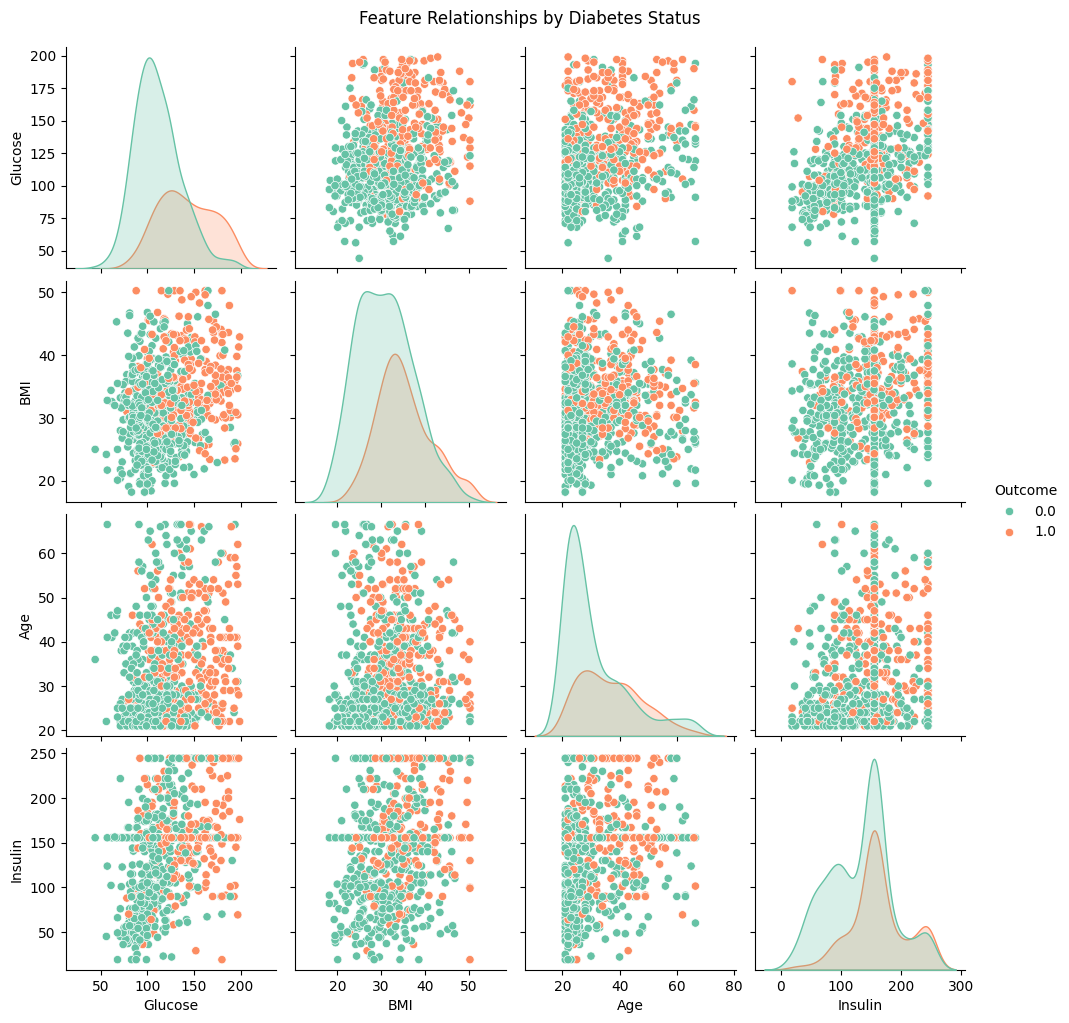

In [71]:
# Scatterplot matrix for key relationships
sns.pairplot(data, vars=['Glucose', 'BMI', 'Age', 'Insulin'],
             hue='Outcome', palette='Set2')
plt.suptitle("Feature Relationships by Diabetes Status", y=1.02)
plt.show()

In [ ]:
# Pairplot - Feature Relationships by Diabetes Status
# 	This scatterplot matrix (pairplot) shows the relationships between different features, color-coded by diabetes status (0 = no diabetes, 1 = diabetes).
# 	The diagonal plots show the distribution of individual features, with separate density plots for each class.
# Key Observations:
# 	Glucose levels: Diabetic patients (orange) tend to have higher glucose levels than non-diabetic patients (green).
# 	BMI: Higher BMI values are more common among diabetics, though there is overlap.
# 	Age: There is no strong separation, but older individuals appear more frequently in the diabetic category.
# 	Insulin levels: Diabetics show a wider range of insulin levels.


In [72]:
# =====================
# 5. VISUALIZATIONS
# =====================

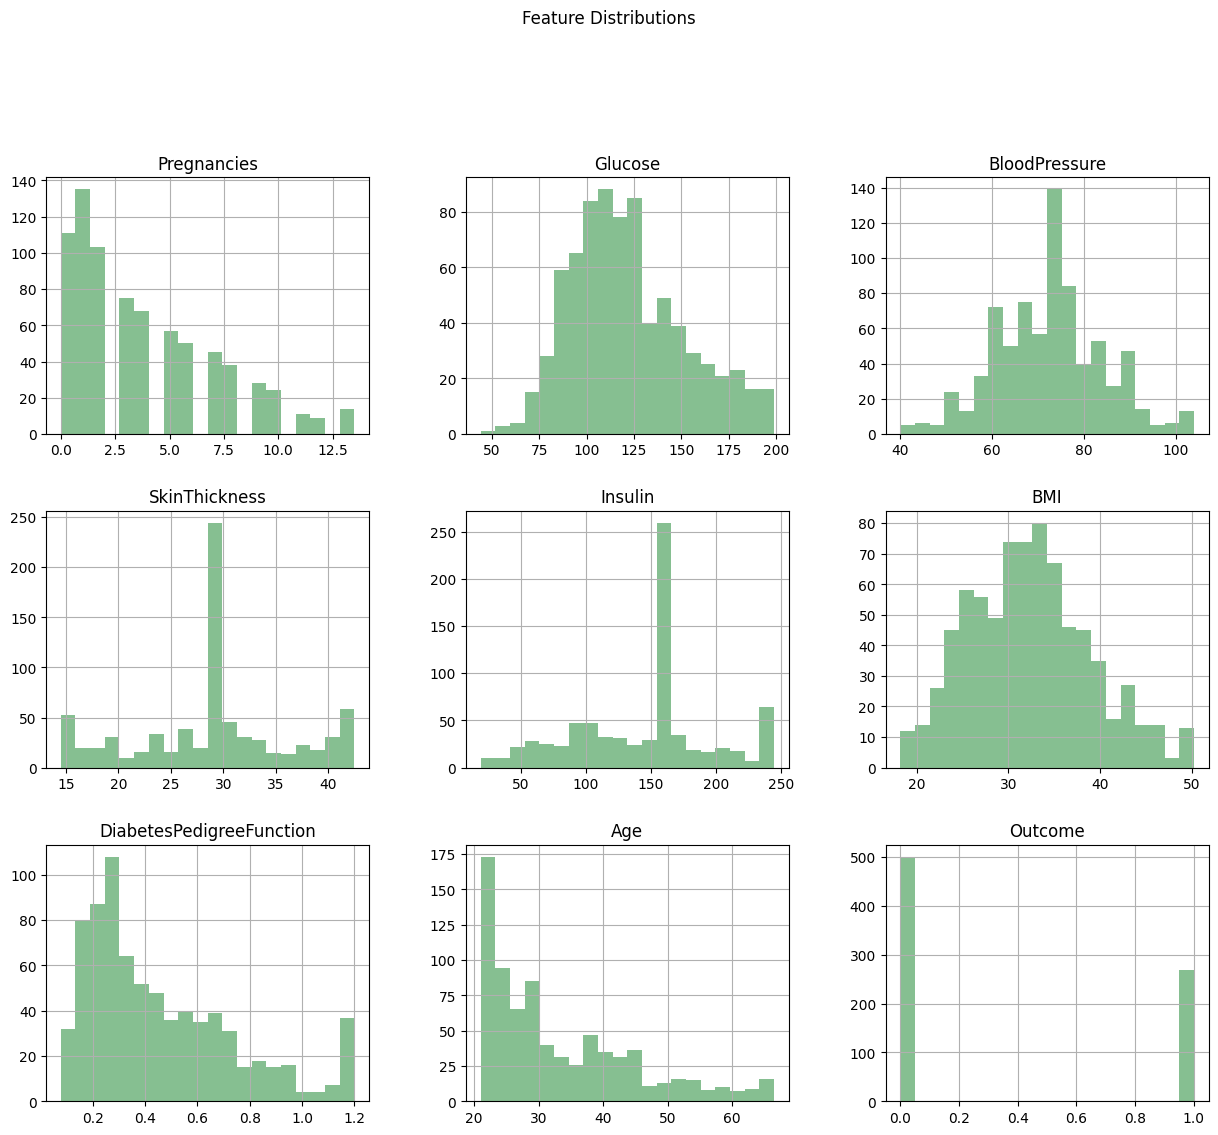

In [73]:
# Histogram distributions
data.hist(figsize=(15,12), bins=20, color='#86bf91')
plt.suptitle("Feature Distributions", y=1.02)
plt.show()

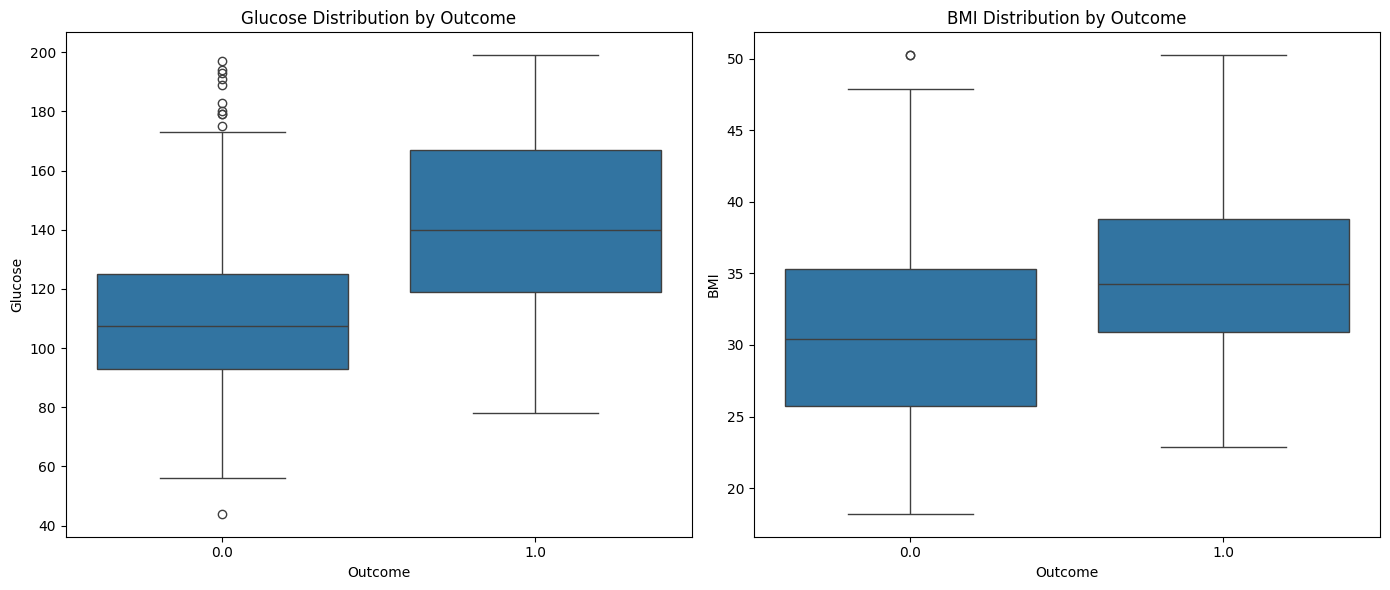

In [74]:
# Boxplot comparisons
fig, ax = plt.subplots(1,2, figsize=(14,6))
sns.boxplot(x='Outcome', y='Glucose', data=data, ax=ax[0])
sns.boxplot(x='Outcome', y='BMI', data=data, ax=ax[1])
ax[0].set_title("Glucose Distribution by Outcome")
ax[1].set_title("BMI Distribution by Outcome")
plt.tight_layout()
plt.show()

In [ ]:
# Key Observations:
# Glucose: Diabetics have significantly higher median glucose levels, with many outliers among non-diabetics.
# BMI: The median BMI for diabetics is higher, though there is overlap.

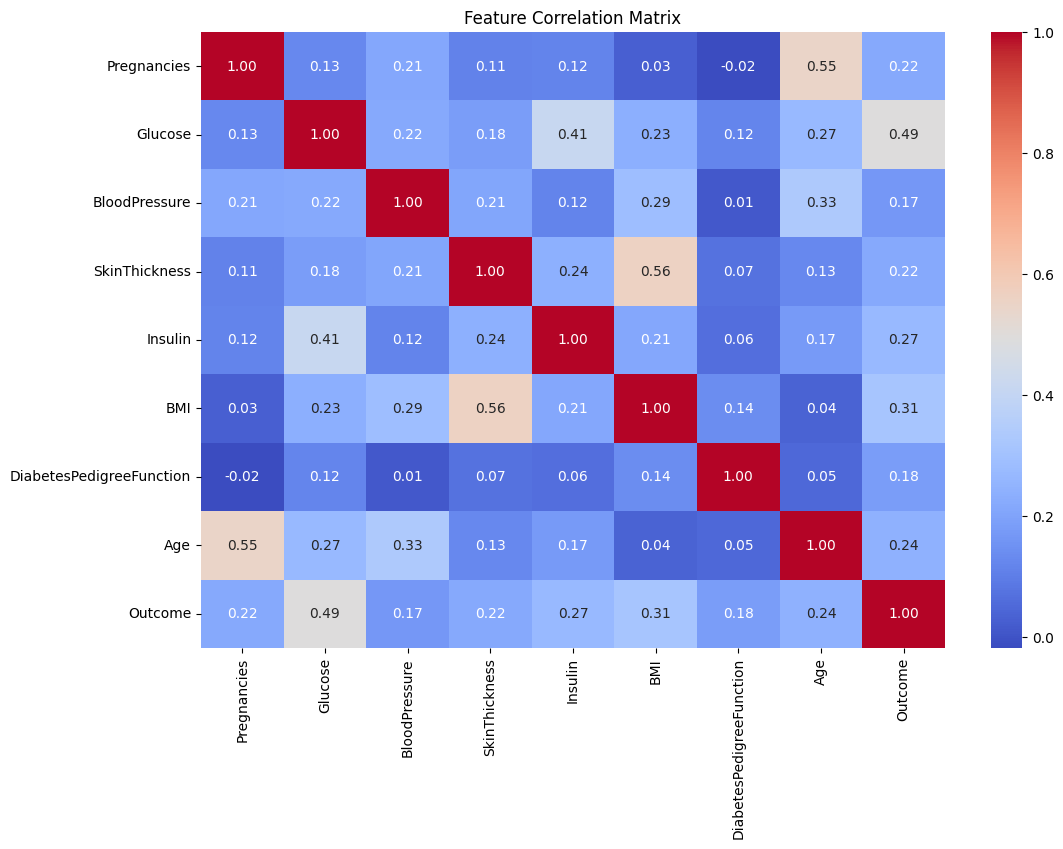

In [75]:
# Heatmap for correlation analysis
plt.figure(figsize=(12,8))
corr_matrix = data.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Feature Correlation Matrix")
plt.show()

In [ ]:

#Heatmap - Feature Correlation Matrix
# •	This heatmap shows the correlation between different features.
# Key Observations:
# •	Glucose and Outcome (0.49 correlation): The strongest predictor of diabetes in this dataset.
# •	BMI and Outcome (0.31 correlation): Important, but weaker than glucose.
# •	Age and Pregnancies correlate (0.55): Older individuals tend to have more pregnancies.
# •	BMI and Skin Thickness (0.56): Expected, as skin thickness is often related to body fat.


In [76]:

# --------------------------
# 6. DATA PREPARATION
# --------------------------

In [77]:
X = data.drop(columns=['Outcome'])
y = data['Outcome']



In [95]:
from imblearn.over_sampling import SMOTE
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Handle class imbalance
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)





Decision Tree Performance:
              precision    recall  f1-score   support

         0.0       0.79      0.78      0.78       150
         1.0       0.60      0.60      0.60        81

    accuracy                           0.72       231
   macro avg       0.69      0.69      0.69       231
weighted avg       0.72      0.72      0.72       231


Random Forest Performance:
              precision    recall  f1-score   support

         0.0       0.80      0.81      0.80       150
         1.0       0.64      0.63      0.63        81

    accuracy                           0.74       231
   macro avg       0.72      0.72      0.72       231
weighted avg       0.74      0.74      0.74       231



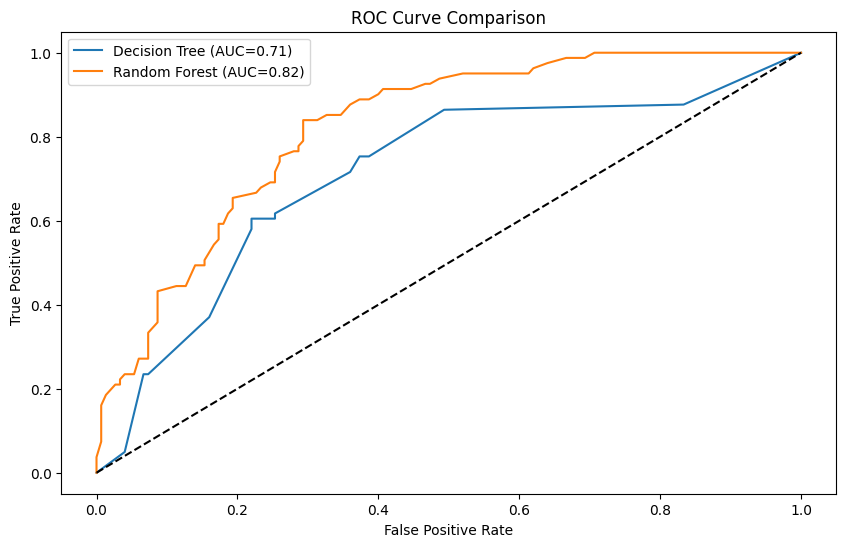

In [90]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_curve, auc
import matplotlib.pyplot as plt

# Define models
models = {
    "Decision Tree": DecisionTreeClassifier(max_depth=5, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(n_estimators=100, class_weight='balanced')
}

# Store results
model_results = {}

plt.figure(figsize=(10, 6))

for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)

    # Predictions
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]  # Probability for ROC

    # Print performance report
    print(f"\n{name} Performance:")
    print(classification_report(y_test, y_pred))

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC={auc(fpr, tpr):.2f})')

    # Store results
    model_results[name] = {
        "Model": model,
        "F1-score": classification_report(y_test, y_pred, output_dict=True)['weighted avg']['f1-score']
    }

# Plot ROC Curve
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()


In [80]:

# --------------------------
# 8. HYPERPARAMETER TUNING
# --------------------------
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV
param_grid = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

dt = DecisionTreeClassifier(class_weight='balanced')
grid_search = GridSearchCV(dt, param_grid, cv=5, scoring='f1')
grid_search.fit(X_train, y_train)
print("\nBest Decision Tree Parameters:", grid_search.best_params_)




Best Decision Tree Parameters: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 5}


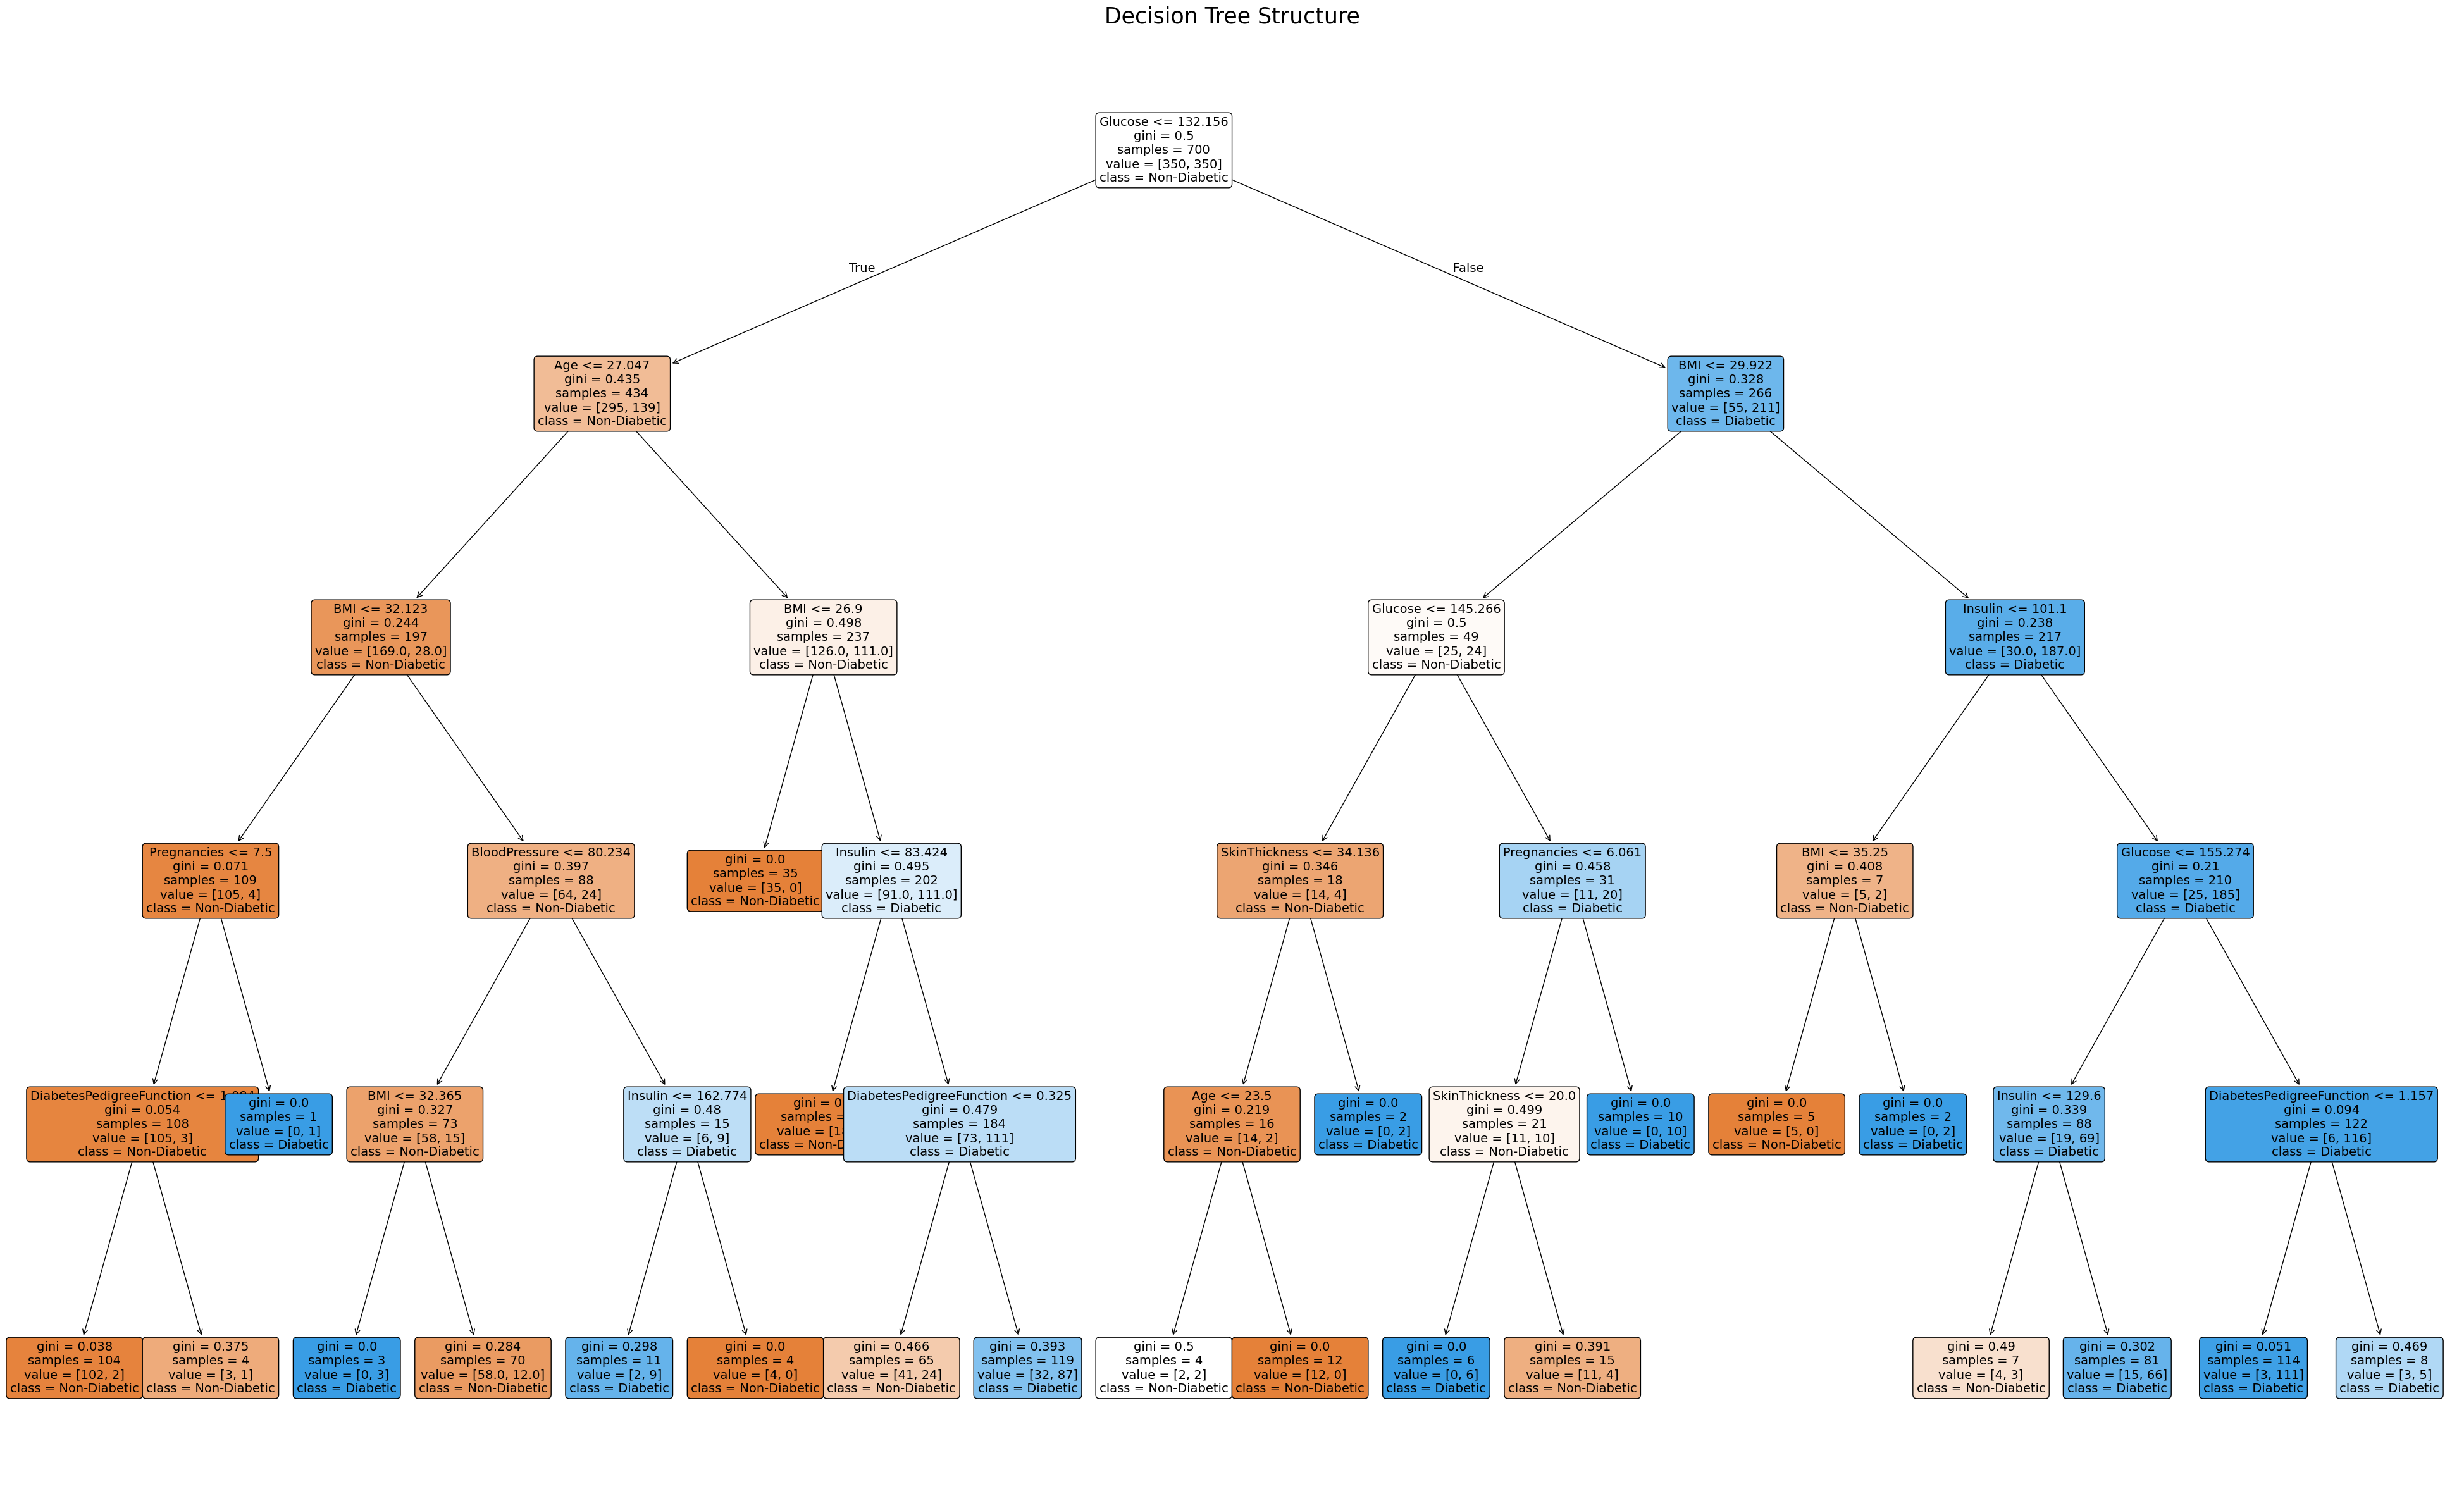

In [92]:
# --------------------------
# 9. MODEL INTERPRETATION
# --------------------------

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
import pandas as pd
import matplotlib.pyplot as plt

# Decision Tree Structure
plt.figure(figsize=(50, 30))  # Large figure size for better visibility
plot_tree(models["Decision Tree"],
          feature_names=X.columns,
          class_names=['Non-Diabetic', 'Diabetic'],
          filled=True,
          rounded=True,
          fontsize=14)  # Increase font size
plt.title("Decision Tree Structure", fontsize=25)  # Title with larger font
plt.savefig("decision_tree.png", dpi=300, bbox_inches='tight')  # Save high-resolution image
plt.show()



In [93]:
# --------------------------
# 10. FINAL MODEL SELECTION
# --------------------------

# Selecting the best model based on F1-score
best_model = max(model_results, key=lambda k: model_results[k]['F1-score'])
best_f1_score = model_results[best_model]['F1-score']

print(f"\nBest Performing Model: {best_model} with F1-score: {best_f1_score:.2f}")





Best Performing Model: Random Forest with F1-score: 0.74


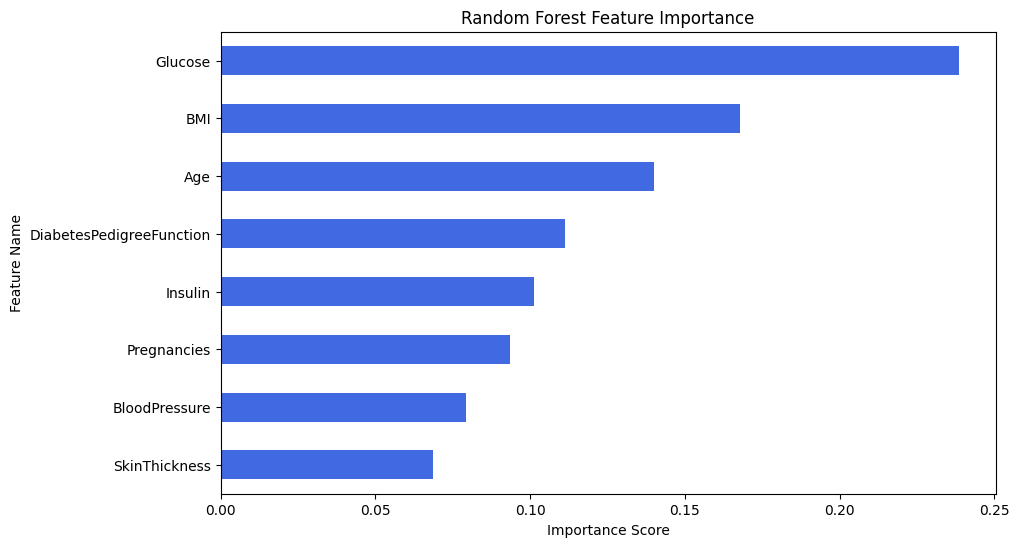


Feature Importance (Decision Tree):
                    Feature  Importance
1                   Glucose    0.405475
5                       BMI    0.207559
7                       Age    0.122587
4                   Insulin    0.113475
6  DiabetesPedigreeFunction    0.066512
3             SkinThickness    0.036839
0               Pregnancies    0.028090
2             BloodPressure    0.019463


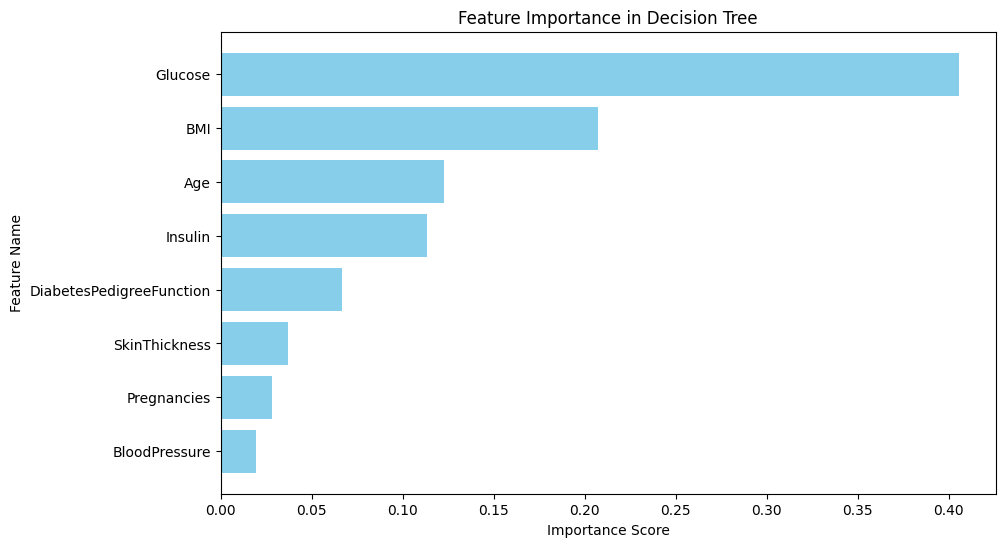

In [94]:
# --------------------------
# 11. FEATURE IMPORTANCE
# --------------------------

# Random Forest Feature Importance
rf = RandomForestClassifier(n_estimators=100, class_weight='balanced')
rf.fit(X_train, y_train)

plt.figure(figsize=(10,6))
pd.Series(rf.feature_importances_, index=X.columns).sort_values().plot(kind='barh', color='royalblue')
plt.title("Random Forest Feature Importance")
plt.xlabel("Importance Score")
plt.ylabel("Feature Name")
plt.show()

# Decision Tree Feature Importance
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': models["Decision Tree"].feature_importances_
}).sort_values(by="Importance", ascending=False)

# Display top features
print("\nFeature Importance (Decision Tree):")
print(feature_importance_df)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel("Importance Score")
plt.ylabel("Feature Name")
plt.title("Feature Importance in Decision Tree")
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()